# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
from importlib.resources import files
import math
import os
import string

import cftime
import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pysteps
import scipy
import xarray as xr

import mlde_utils
from mlde_analysis import plot_map, distribution_figure, plot_mean_bias, plot_std_bias, scatter_plots, freq_density_plot
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS, platecarree, dataset_split_path
from mlde_analysis.data import prep_eval_data, open_concat_sample_datasets, si_to_mmday
from mlde_analysis import create_map_fig, STYLES
from mlde_analysis.distribution import normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases
# from mlde_analysis.wet_dry import wet_dry_dataframe, wet_dry_ratio, wet_dry_ratio_error, plot_wet_dry_errors

xr.set_options(display_style="html")

cannot find .env file


Pysteps configuration file found at: /home/users/vf20964/mambaforge/envs/mlde-notebooks/lib/python3.9/site-packages/pysteps/pystepsrc



<xarray.core.options.set_options>

In [ ]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6

sample_configs_at_60km = [
    {
        "label": "CPMGEM_GCM@60km",
        "sample_specs": [{
            "fq_model_id": "score-sde/demo-cpmgem-pr/postprocess/gcm-grid",
            "checkpoint": "epoch_20",
            "input_xfm": "demo-gcm_pr-pixelmmsstan",
            "label": "CPMGEM-GCM@60km",
            "dataset": "demo-gcm_pr",
            "variables": ["pr"],
        }],
        "deterministic": False,
    },
]

dataset_configs_at_60km = {
    "CPM": "demo-ccpm-60km_pr",
    "GCM": "demo-gcm-60km_pr",
}

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM_GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
precomp_60km_ds = open_concat_sample_datasets(sample_configs_at_60km, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run).squeeze("model")
precomp_60km_ds

<xarray.Dataset>
Dimensions:          (time: 3240, longitude: 9, latitude: 9,
                      ensemble_member: 12, sample_id: 6)
Coordinates:
  * time             (time) object 1981-03-01 12:00:00 ... 2076-08-30 12:00:00
  * longitude        (longitude) float32 -5.417 -4.583 -3.75 ... 0.4167 1.25
  * latitude         (latitude) float32 50.28 50.83 51.39 ... 53.61 54.17 54.72
  * ensemble_member  (ensemble_member) object '01' '04' '05' ... '12' '13' '15'
    model            <U15 'CPMGEM_GCM@60km'
Dimensions without coordinates: sample_id
Data variables:
    pred_pr          (sample_id, ensemble_member, time, latitude, longitude) float32 ...
Attributes:
    units:          mm/day
    grid_mapping:   latitude_longitude
    standard_name:  precipitation_flux
    long_name:      Precip.

In [ ]:
raw_gcm_pr = si_to_mmday(xr.open_dataset(dataset_split_path(dataset_configs_at_60km["GCM"], split))["pr"])
raw_gcm_pr

<xarray.DataArray 'pr' (ensemble_member: 12, time: 3240, latitude: 9,
                        longitude: 9)>
array([[[[1.07989597e+00, 9.39629197e-01, 8.68907094e-01, ...,
          5.58326364e-01, 1.14393461e+00, 2.78060913e+00],
         [2.06988239e+00, 1.55580461e+00, 1.41878688e+00, ...,
          3.96716535e-01, 7.06022561e-01, 1.33882475e+00],
         [1.81687236e+00, 2.21250439e+00, 1.86729217e+00, ...,
          6.14619374e-01, 7.44198442e-01, 7.61534035e-01],
         ...,
         [1.16284907e-01, 6.74738765e-01, 2.25295138e+00, ...,
          7.95830250e-01, 2.87753165e-01, 2.13433519e-01],
         [4.30636346e-01, 1.05904031e+00, 3.38295650e+00, ...,
          4.75975782e-01, 1.63056422e-02, 3.49233001e-01],
         [5.97246647e-01, 4.93944108e-01, 1.94049919e+00, ...,
          8.26783106e-03, 1.07494164e-02, 4.82962020e-02]],

        [[4.98914942e-02, 4.76445928e-02, 3.98279168e-02, ...,
          1.14780059e-02, 1.29252840e-02, 9.75106191e-03],
         [9.00599435e-02, 2.50165582e-01, 1.46175876e-01, ...,
          1.76643223e-01, 2.05229431e-01, 8.59191176e-03],
         [2.53796935e-01, 8.13750565e-01, 9.79342222e-01, ...,
          6.80484325e-02, 6.26696348e-02, 3.97420526e-02],
...
          0.00000000e+00, 1.91385935e-10, 6.69069383e-11],
         [1.64297577e-02, 1.23316515e-02, 1.38152859e-06, ...,
          3.23693925e-08, 0.00000000e+00, 0.00000000e+00],
         [4.39179683e-04, 1.03622638e-02, 6.18007092e-04, ...,
          2.94203346e-04, 2.10105063e-04, 1.12844119e-03]],

        [[1.08020818e-02, 2.21866998e-03, 1.58097915e-04, ...,
          5.43524038e-06, 2.10292274e-05, 0.00000000e+00],
         [1.75936781e-02, 3.49990907e-04, 7.82681919e-09, ...,
          0.00000000e+00, 1.27427298e-13, 1.44309512e-11],
         [1.19257635e-02, 4.79862280e-02, 0.00000000e+00, ...,
          0.00000000e+00, 2.29847274e-06, 5.93178999e-03],
         ...,
         [1.25835299e-01, 3.79063338e-02, 1.72691140e-02, ...,
          2.72890815e-04, 8.50719679e-03, 1.65075120e-02],
         [2.83731133e-01, 7.04994425e-02, 4.14202958e-02, ...,
          6.60864590e-03, 1.40075218e-02, 3.81202362e-02],
         [1.64280042e-01, 9.07699838e-02, 1.87290087e-02, ...,
          6.41418714e-03, 3.92445223e-03, 1.60384737e-02]]]],
      dtype=float32)
Coordinates:
  * time             (time) object 1981-03-01 12:00:00 ... 2076-08-30 12:00:00
  * latitude         (latitude) float32 50.28 50.83 51.39 ... 53.61 54.17 54.72
  * longitude        (longitude) float32 -5.417 -4.583 -3.75 ... 0.4167 1.25
  * ensemble_member  (ensemble_member) object '01' '04' '05' ... '12' '13' '15'
    season           (time) float64 ...
Attributes:
    units:          mm/day
    grid_mapping:   latitude_longitude
    standard_name:  precipitation_flux
    long_name:      Precip.

In [ ]:
cpm_pr_on_gcm = si_to_mmday(xr.open_dataset(dataset_split_path(dataset_configs_at_60km["CPM"], split))["pr"])
cpm_pr_on_gcm

<xarray.DataArray 'pr' (ensemble_member: 12, time: 3240, latitude: 9,
                        longitude: 9)>
array([[[[1.61350942e+00, 1.51789331e+00, 1.28416908e+00, ...,
          1.43129659e+00, 2.31606054e+00, 3.94082785e+00],
         [1.02021754e+00, 1.47165763e+00, 2.54407692e+00, ...,
          7.15185165e-01, 6.43451095e-01, 9.79567587e-01],
         [2.55971169e+00, 2.58173919e+00, 3.46543908e+00, ...,
          6.43982351e-01, 1.89472765e-01, 1.74332842e-01],
         ...,
         [3.68333006e+00, 1.94820023e+00, 1.36737180e+00, ...,
          4.32916492e-01, 1.91135511e-01, 2.68457197e-02],
         [8.80109906e-01, 6.81615353e-01, 8.95869970e-01, ...,
          8.25099528e-01, 3.89871411e-02, 7.54438952e-05],
         [8.73785555e-01, 3.28913897e-01, 7.68671632e-01, ...,
          3.69609118e-01, 6.25182912e-02, 9.41992737e-03]],

        [[6.67130644e-06, 8.23823029e-06, 3.14262550e-04, ...,
          1.24722451e-01, 6.72306716e-02, 1.68032665e-02],
         [7.69986361e-02, 4.99189720e-02, 1.37238316e-02, ...,
          2.09784865e-01, 3.80491198e-04, 4.85768169e-03],
         [2.03642845e-01, 1.09121308e-01, 1.75440133e-01, ...,
          1.97643250e-01, 5.68546116e-01, 2.00092852e-01],
...
          4.50032018e-03, 6.47400273e-04, 1.78435148e-04],
         [3.71746195e-04, 1.69404215e-04, 2.27855518e-04, ...,
          5.13872328e-06, 9.97856405e-05, 3.03206732e-04],
         [5.94204757e-04, 3.35640390e-04, 2.94071622e-04, ...,
          9.30020033e-05, 3.67379980e-04, 2.79585482e-04]],

        [[2.90042879e-10, 0.00000000e+00, 0.00000000e+00, ...,
          2.94193446e-12, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 2.80531822e-05, ...,
          6.05008710e-09, 1.75559123e-07, 4.47708363e-12],
         [0.00000000e+00, 0.00000000e+00, 1.23599238e-11, ...,
          8.82998279e-08, 0.00000000e+00, 0.00000000e+00],
         ...,
         [5.53121345e-06, 3.52500547e-06, 9.05562683e-06, ...,
          4.42191958e-05, 8.87608767e-05, 1.06496467e-04],
         [6.58447470e-06, 8.37299285e-06, 7.14171892e-06, ...,
          2.31850754e-05, 1.44716338e-04, 1.53816858e-04],
         [9.67582309e-07, 1.08021977e-05, 5.69276090e-05, ...,
          8.43206653e-05, 7.57013186e-05, 8.55379621e-05]]]],
      dtype=float32)
Coordinates:
  * time             (time) object 1981-03-01 12:00:00 ... 2076-08-30 12:00:00
  * longitude        (longitude) float32 -5.417 -4.583 -3.75 ... 0.4167 1.25
  * latitude         (latitude) float32 50.28 50.83 51.39 ... 53.61 54.17 54.72
  * ensemble_member  (ensemble_member) object '01' '04' '05' ... '12' '13' '15'
    season           (time) float64 ...
Attributes:
    units:          mm/day
    grid_mapping:   latitude_longitude
    standard_name:  precipitation_flux
    long_name:      Precip.

### frequency distribution on the coarse grid, bias in mean and std. dev.

In [ ]:
hist_data = [
    dict(data=precomp_60km_ds["pred_pr"], label=sample_configs_at_60km[0]["label"], color="tab:green"),
    dict(data=raw_gcm_pr, label="GCM", color="tab:purple"),]

mean_biases = [ dict(data=normalized_mean_bias(hd["data"], cpm_pr_on_gcm), label=hd["label"]) for hd in hist_data ]

std_biases = [ dict(data=normalized_std_bias(hd["data"], cpm_pr_on_gcm), label=hd["label"]) for hd in hist_data ]

Text(0.04, 0.5, 'Std. dev.')

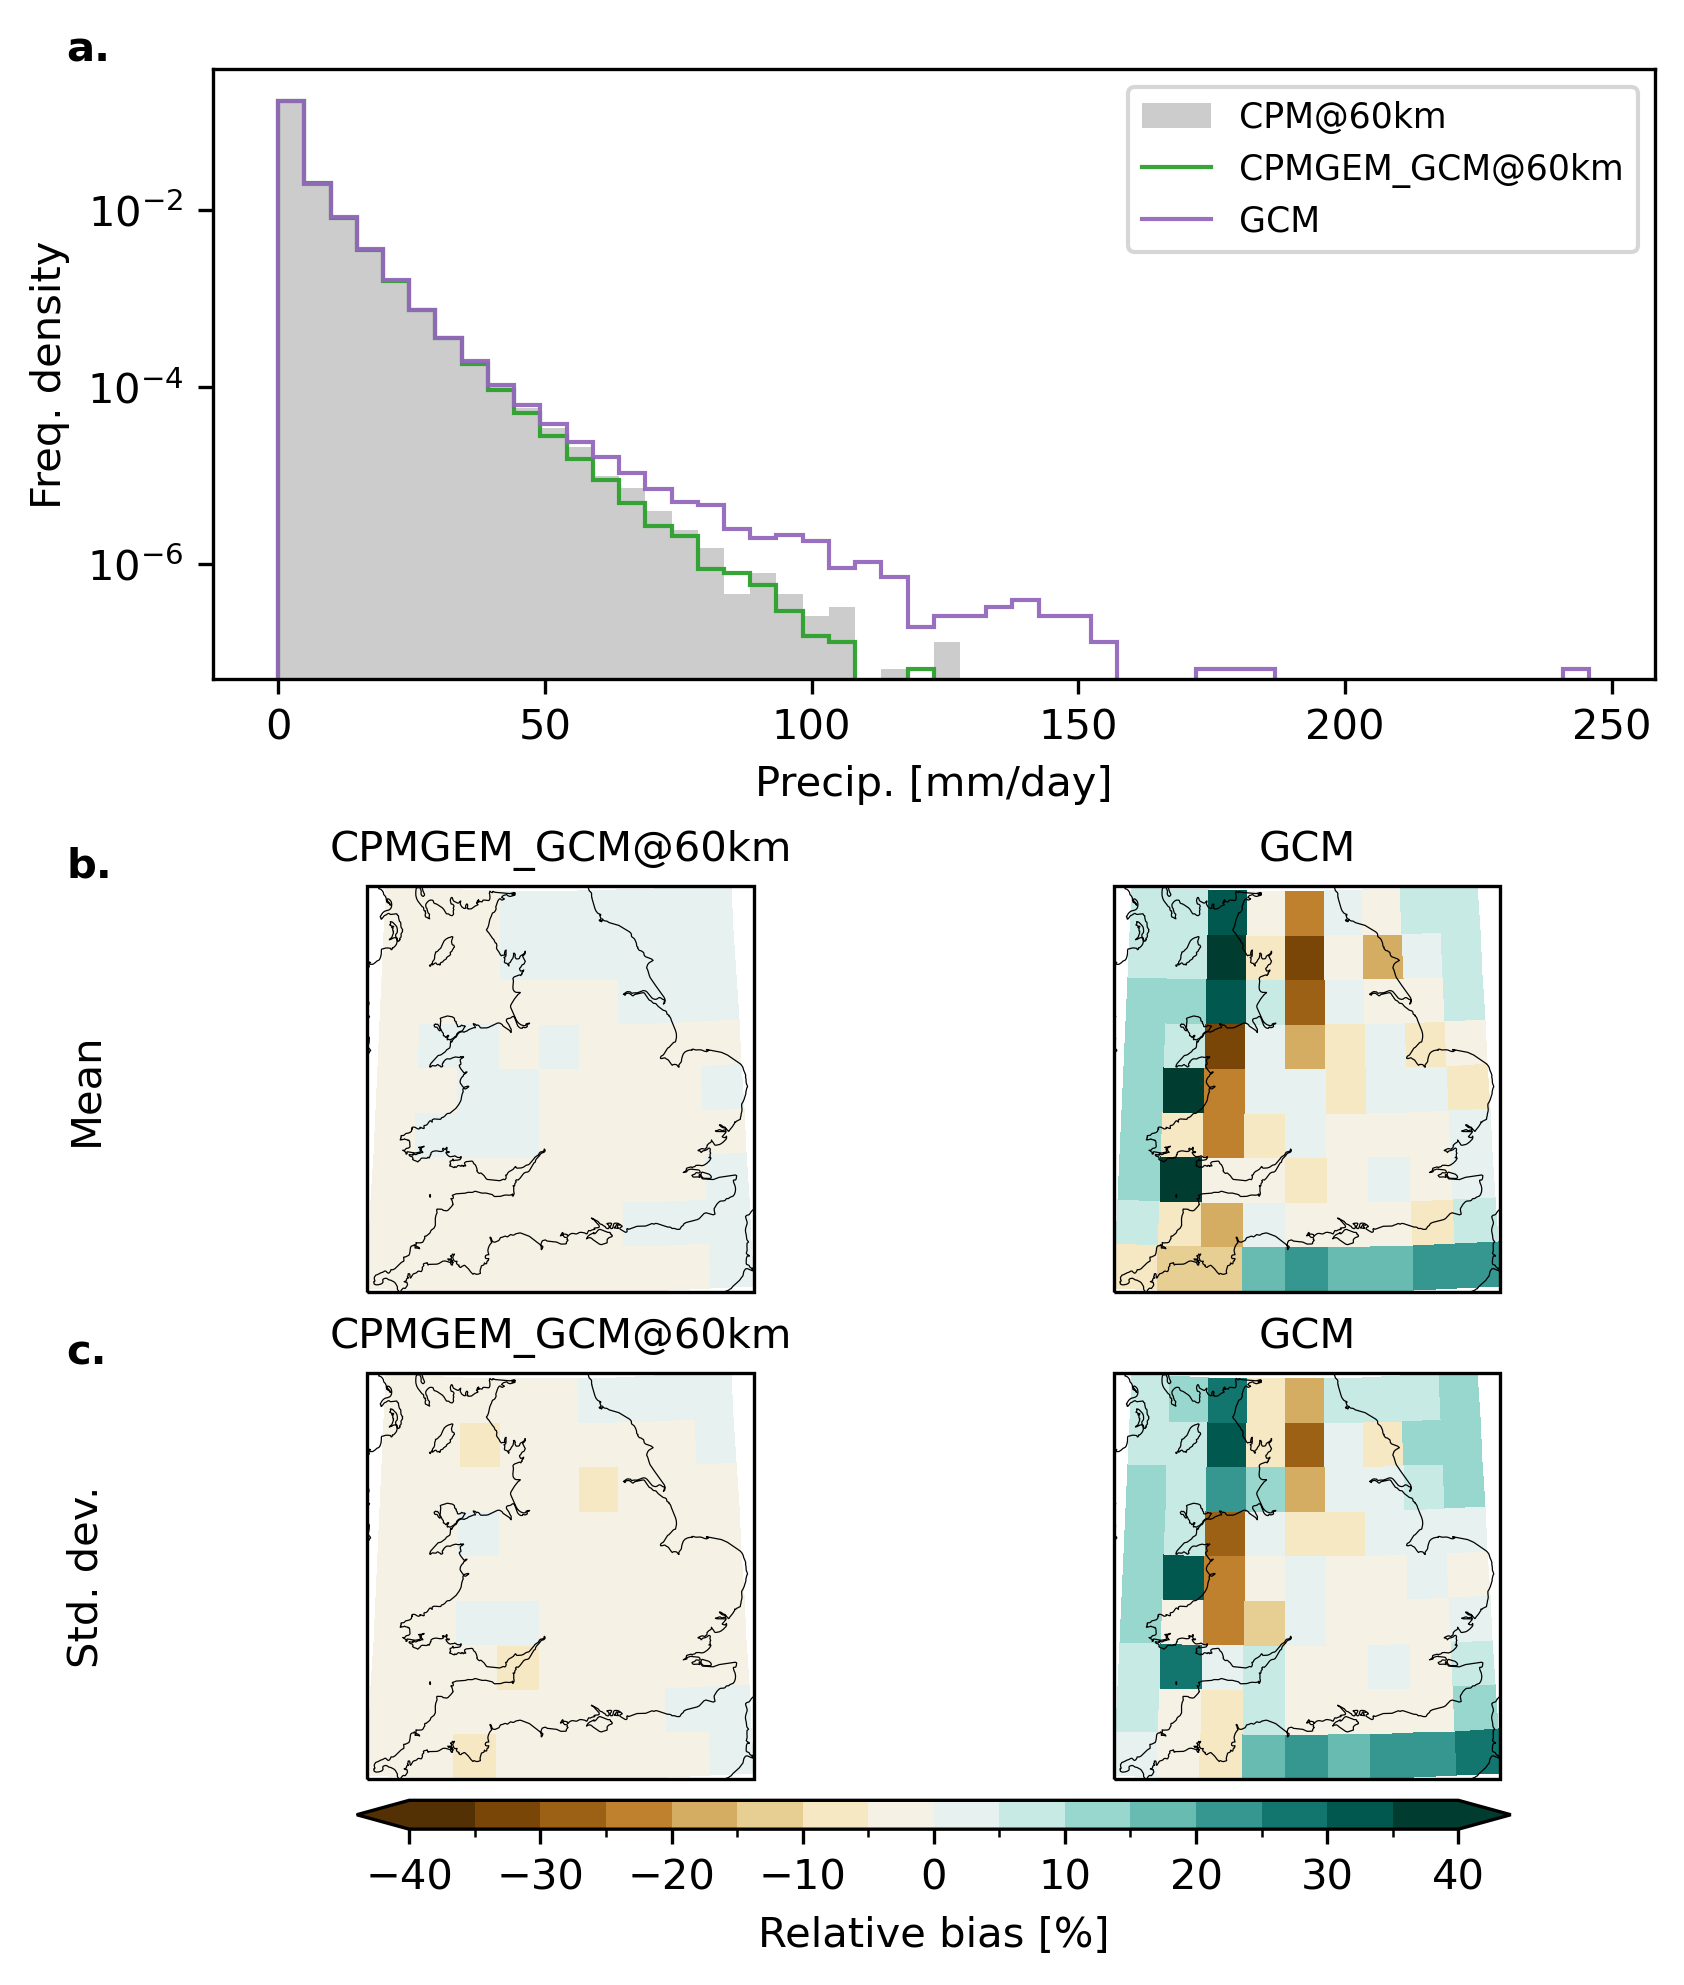

In [ ]:
fig = plt.figure(layout='constrained', figsize=(5.5, 6.5))

meanb_axes_keys = list([f"meanb {mb['label']}" for mb in mean_biases])
meanb_spec = np.array(meanb_axes_keys).reshape(1,-1)

stddevb_axes_keys = list([f"stddevb {sb['label']}" for sb in std_biases])
stddevb_spec = np.array(stddevb_axes_keys).reshape(1,-1)

density_axes_keys = ["density"]
density_spec = np.array(density_axes_keys*meanb_spec.shape[1]).reshape(1,-1)

spec = np.concatenate([density_spec, meanb_spec, stddevb_spec], axis=0)

axd = fig.subplot_mosaic(spec, gridspec_kw=dict(height_ratios=[3, 2, 2]), per_subplot_kw={ak: {"projection": cp_model_rotated_pole} for ak in meanb_axes_keys + stddevb_axes_keys})

ax = axd["density"]
plot_freq_density(hist_data, target_da=cpm_pr_on_gcm, ax=ax, target_label="CPM@60km", linewidth=1)
ax.annotate("a.", xy=(0.04, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")

axes = plot_mean_biases(mean_biases, axd, transform=platecarree)
axes[0].annotate("b.", xy=(0.04, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")
axes[0].annotate("Mean", xy=(0.04, 0.5), xycoords=("figure fraction", "axes fraction"), ha="left", va="center", fontsize="medium", rotation=90)

axes = plot_std_biases(std_biases, axd, transform=platecarree)
axes[0].annotate("c.", xy=(0.04, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")
axes[0].annotate("Std. dev.", xy=(0.04, 0.5), xycoords=("figure fraction", "axes fraction"), ha="left", va="center", fontsize="medium", rotation=90)

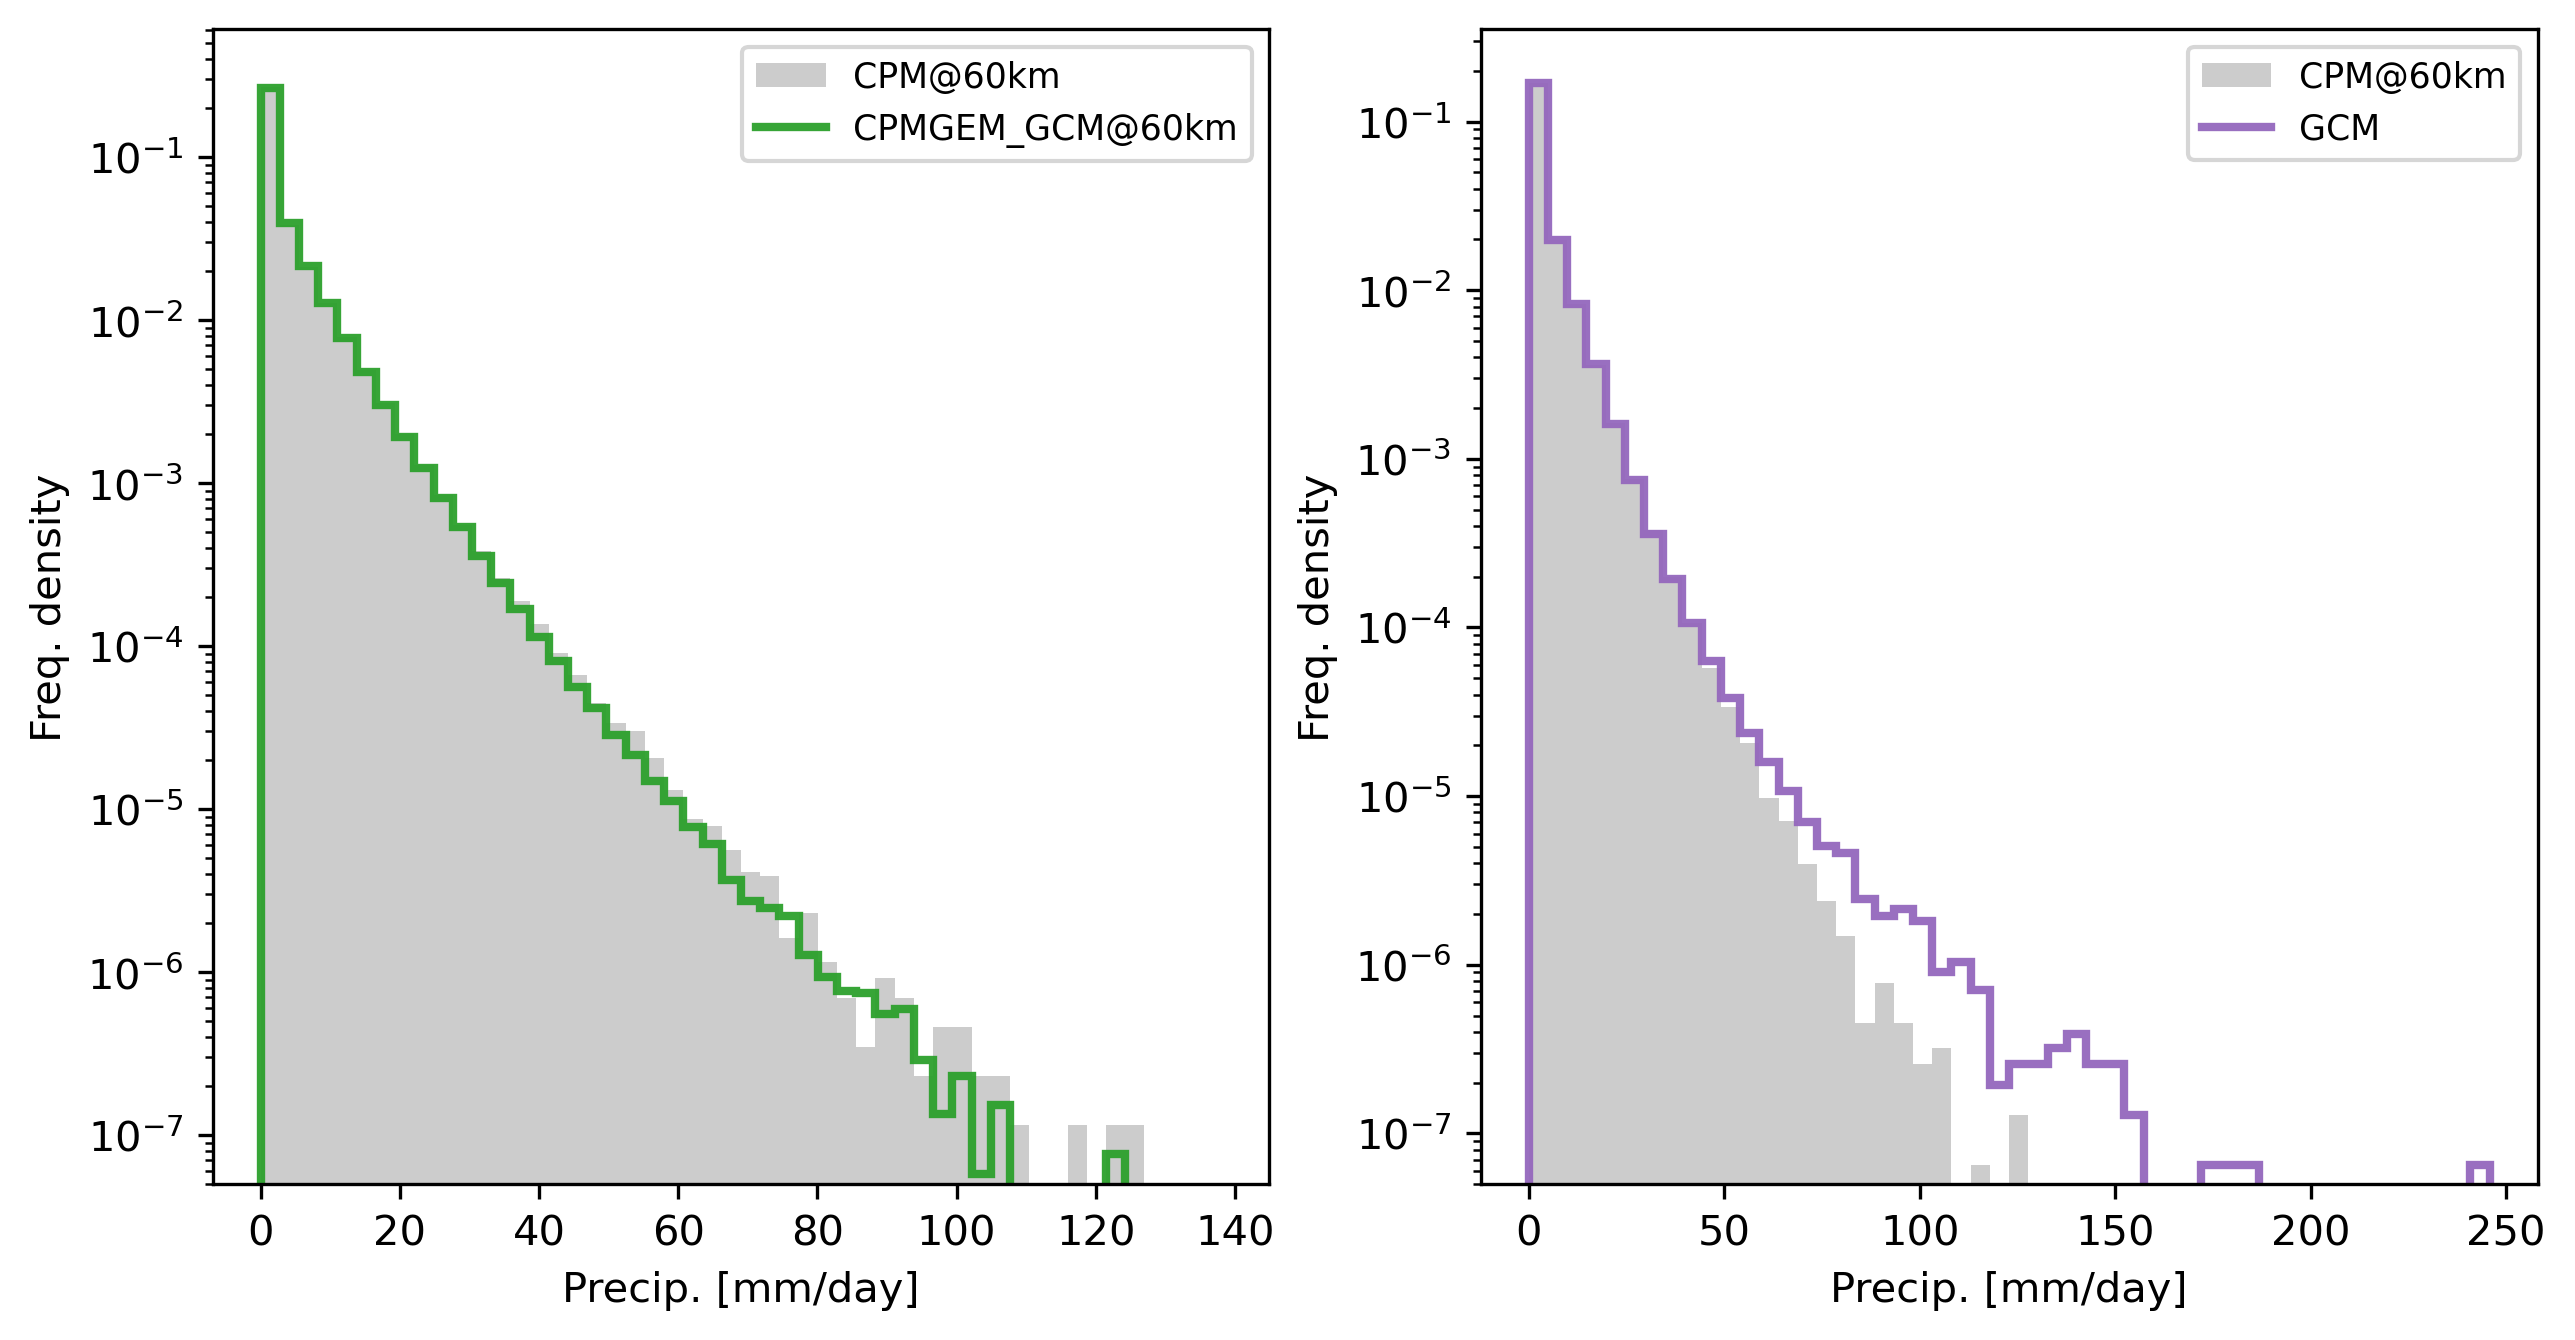

In [ ]:
density_axes_keys = list(map(lambda x: f"density {x}", [ hd["label"] for hd in hist_data ]))
if len(density_axes_keys) % 2 == 1:
    density_axes_keys = density_axes_keys + ["."]
density_spec = np.array(density_axes_keys).reshape(-1,2)

fig = plt.figure(figsize=(10, 5*density_spec.shape[0]))

axd = fig.subplot_mosaic(density_spec)

for hd in hist_data:
    ax = axd[f"density {hd['label']}"]
    plot_freq_density([hd], target_da=cpm_pr_on_gcm, ax=ax, target_label="CPM@60km")